In [5]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent)) 

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.backbones import get_model
from src.utils import augment_image
from pathlib import Path

In [9]:
#Params
master_image_dir = Path("../master")
masking = False
rotation = False

In [10]:
# Load DINOv2 model
model = get_model('dinov2_vits14', 'cuda', smaller_edge_size=512, feat_layer=10) # feat_layer:0~11
# model = get_model('dinov2_vitb14', 'cuda', smaller_edge_size=512, feat_layer=9) # feat_layer:0~11
# model = get_model('dinov2_vitl14', 'cuda', smaller_edge_size=512, feat_layer=13) # feat_layer:0~23

Loading model: dinov2_vits14
Device: cuda


Using cache found in /home/user/.cache/torch/hub/facebookresearch_dinov2_main


Successfully saved


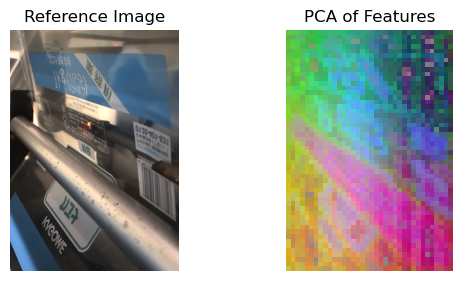

Successfully saved


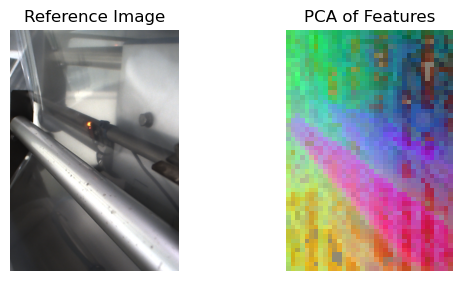

Successfully saved


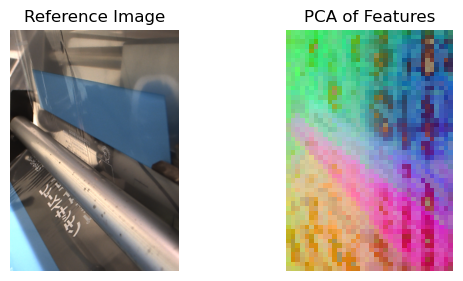

Successfully saved


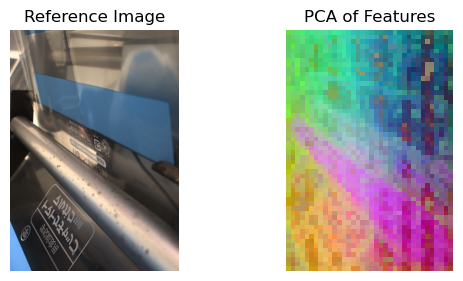

Successfully saved


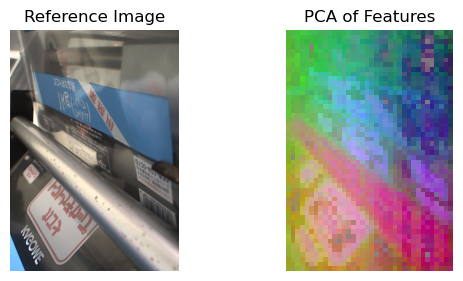

Successfully saved


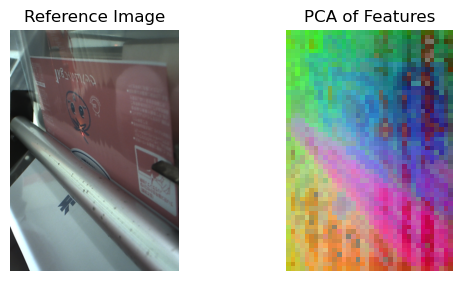

In [11]:
# Search master images
master_image_path_list = [p for p in master_image_dir.rglob('*') if p.is_file() and p.suffix.lower() in {'.bmp'}]

for master_image_path in master_image_path_list:
    # Load reference image
    master_image = cv2.cvtColor(cv2.imread(master_image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    # rotaion処理
    if rotation:
        img_augmented = augment_image(master_image)
        
        master_features_rotate = []
        for img in img_augmented:
            master_tensor_rotate, grid_size_rotate = model.prepare_image(img)
            feature_rotate = model.extract_features(master_tensor_rotate)
            mask = model.compute_background_mask(feature_rotate, grid_size_rotate, threshold=10, masking_type=masking)
            vis_image = model.get_embedding_visualization(feature_rotate, grid_size_rotate)
            master_features_rotate.append(feature_rotate)

        concat_feature = np.concatenate(master_features_rotate, axis=0)

        # Save feature
        out_path_rotate = master_image_path.with_name(f"{master_image_path.stem}_rotate.npy")
        np.save(out_path_rotate, concat_feature)
        print("Successfully saved")
        
    else:
        master_tensor, grid_size = model.prepare_image(master_image)
        feature = model.extract_features(master_tensor)
        mask = model.compute_background_mask(feature, grid_size, threshold=10, masking_type=masking)
        vis_image = model.get_embedding_visualization(feature, grid_size)

        # Save feature
        out_path = master_image_path.with_name(f"{master_image_path.stem}.npy")
        np.save(out_path, feature)
        print("Successfully saved")
    
    # Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(master_image)
    ax2.imshow(vis_image)
    fig.tight_layout()
    ax1.axis('off')
    ax1.set_title("Reference Image")
    ax2.axis('off')
    ax2.set_title("PCA of Features")
    plt.show()